In [1]:
import sys
sys.path.append('..')  # Go up one directory from notebooks/ to project root

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
import pandas as pd
from pathlib import Path

# Local imports
from src.styles import style_config

In [2]:
# Load data
data = pd.read_csv('../data/summary.csv')

data.head()

,player_id,short_name,role,minutes_played,xD,danger_passes,xD_per_90,danger_passes_per_90
0,38021,K. De Bruyne,Midfielder,1142.0,7.586102,79,0.597854,6.225919
1,11051,J. Grealish,Forward,655.0,4.112759,51,0.565112,7.007634
2,397098,R. Nelson,Forward,531.0,3.184809,38,0.539798,6.440678
3,302292,M. Ødegaard,Midfielder,1738.0,9.628683,111,0.498608,5.747986
4,14911,Son Heung-Min,Forward,1900.0,10.116624,108,0.479209,5.115789


In [14]:
def create_ranking_plot(ranking, role, metric, n=10):
    """ 
    Create a ranking plot for a given metric and role.

    Parameters
    ----------
    ranking: pd.DataFrame
        A dataframe with player stats. Ranked by a given metric.
    role: str
        The role of the players in the ranking.
    n: int
        The number of players to include in the ranking.

    Returns
    -------
    fig: plt.Figure
        A matplotlib figure.
    """
    # Apply styling
    plt.rcParams['font.family'] = style_config['fonts']['light'].get_name()
    plt.rcParams.update({
        'text.color': style_config['colors']['dark'],
        'axes.labelcolor': style_config['colors']['dark'],
        'axes.edgecolor': style_config['colors']['dark'],
        'xtick.color': style_config['colors']['dark'],
        'ytick.color': style_config['colors']['dark'],
        'grid.color': style_config['colors']['dark'],
        'figure.facecolor': style_config['colors']['background'],
        'axes.facecolor': style_config['colors']['background'],
    })

    # Create figure
    fig = plt.figure(figsize=(12, 1 + 0.6 * len(ranking)))      # Increase height of figure based on number of rows in ranking
    gs = fig.add_gridspec(3, 1, height_ratios=[0.1, 0.8, 0.1])       # 2 rows, 1 column, with height ratios for title, plot, legend

    # Init axis
    heading_ax = fig.add_subplot(gs[0])
    main_ax = fig.add_subplot(gs[1])
    legend_ax = fig.add_subplot(gs[2])

    # Hide axis
    heading_ax.axis('off')
    legend_ax.axis('off')

    # Hide spines
    main_ax.spines['top'].set_visible(False)
    main_ax.spines['bottom'].set_visible(False)
    main_ax.spines['left'].set_visible(False)
    main_ax.spines['right'].set_visible(False)

    # Remove axis ticks
    main_ax.set_yticklabels([])
    main_ax.set_yticks([])
    main_ax.set_xticks([])

    # Title
    heading_ax.text(
        0, 
        0.5, 
        f"Top {n} {role}s in the Premier League 2024/2025",
        fontsize=style_config['sizes']['h1'],
        fontproperties=style_config['fonts']['medium_italic'],
        ha='left', 
        va='bottom'
    )

    # Subtitle
    label = "xD per 90" if metric == "xD_per_90" else "Danger Passes per 90"
    heading_ax.text(
        0, 
        0, 
        f'{label} by players with at least 400 minutes played', 
        fontsize=style_config['sizes']['p'],
        ha='left',
        va='bottom'
    )

    # PL logo
    logo_path = '../assets/pl-logo.png'
    logo = mpimg.imread(logo_path)
    imagebox = OffsetImage(logo, zoom=0.25)
    ab = AnnotationBbox(
        imagebox, 
        (1, 0),                     # location of annotation box
        xycoords='axes fraction',   # use axes fraction coordinates: relative to axes and percentage of axes for position
        box_alignment=(1, 0),       # alignment of the annotation box: (1, 0) means right-aligned and bottom-aligned
        frameon=False               # don't show the frame of the annotation box
    )
    heading_ax.add_artist(ab)

    # Set offset
    offset = 0.02 * ranking[metric].max()

    # Loop through ranking to plot data, names and metric values
    for i, row in ranking.iterrows():
        # Plot data
        main_ax.barh(
            row['short_name'], 
            row[metric], 
            color=style_config['colors'][role.lower()], 
            alpha=style_config['alpha']
        )

        # Plot player name
        main_ax.text(
            0 - offset, 
            i,
            f"{row['short_name']}", 
            fontsize=style_config['sizes']['label'] + 2,
            fontproperties=style_config['fonts']['medium'],
            ha='right',
            va='center',
        )

        # Display metric value
        main_ax.text(
            row[metric] + offset, 
            row['short_name'], 
            f"{row[metric]:.3f}", 
            fontsize=style_config['sizes']['label'] + 2,
            fontproperties=style_config['fonts']['medium'],
            va='center', 
            ha='left', 
        )

    # Set legend text
    xD_text = 'Expected Danger (xD) is a \'danger score\' that tells us how likely a pass is to create a real scoring threat.\nIt\'s calculated by multiplying the probability of a pass leading to a shot with the probability of that shot being a goal.'
    danger_text = 'Danger passes are passes that end in a shot within 15 seconds.\nThese stats are standardized to 90 minutes played to be able to easily compare players with different playing times.'
    legend_text = xD_text if metric == 'xD_per_90' else danger_text
    legend_ax.text(
        0, 
        1, 
        legend_text,
        fontsize=style_config['sizes']['label'], 
        ha='left', 
        va='top'
    )

    # Save image
    default_kwargs = {
        'bbox_inches': 'tight',
        'pad_inches': 0.5,
        'facecolor': style_config['colors']['background'],
        'dpi': 300
    }

    output_path = f'../generated_plots/rankings/{role.lower()}-{metric.replace('_', '-')}.png'
    fig.savefig(output_path, **default_kwargs)

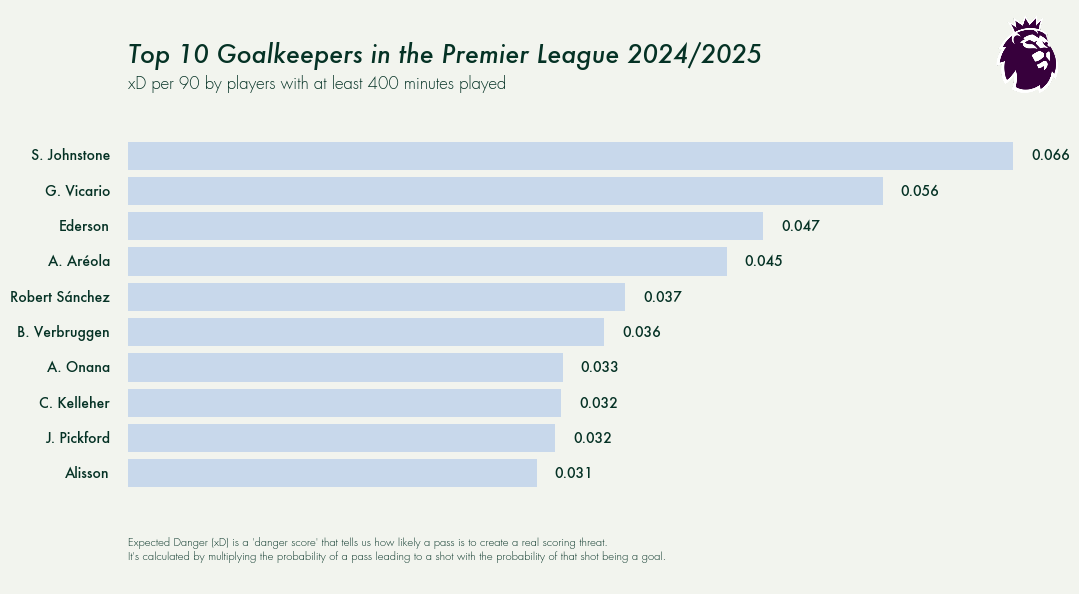

In [15]:
# test plotting function
ranking = data[data['role'] == 'Goalkeeper'].sort_values(by='xD_per_90', ascending=True).tail(10).reset_index(drop=True)
create_ranking_plot(ranking, 'Goalkeeper', 'xD_per_90', 10)
plt.show()

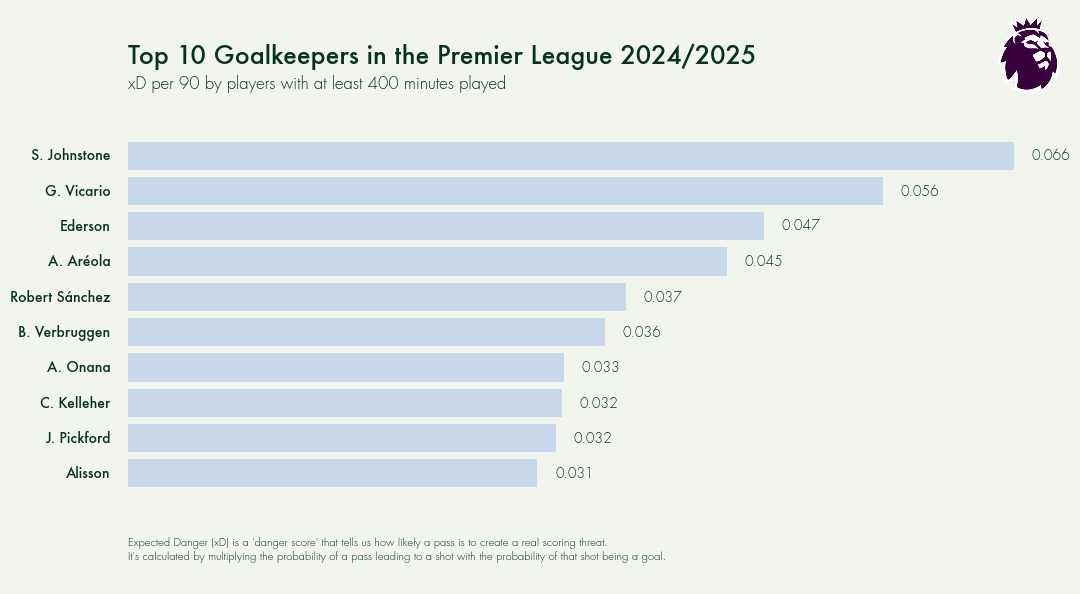

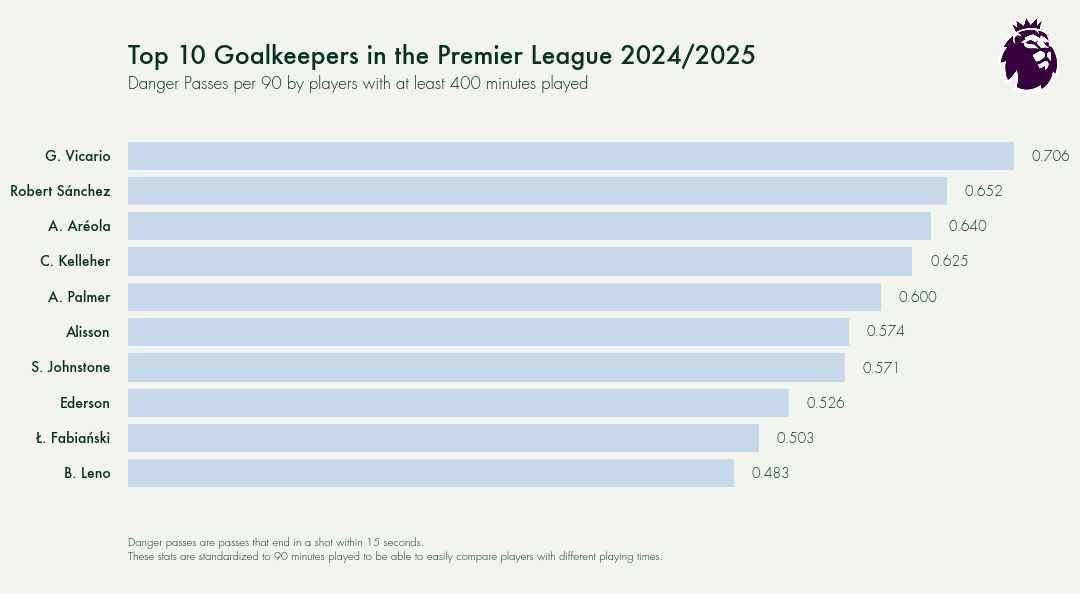

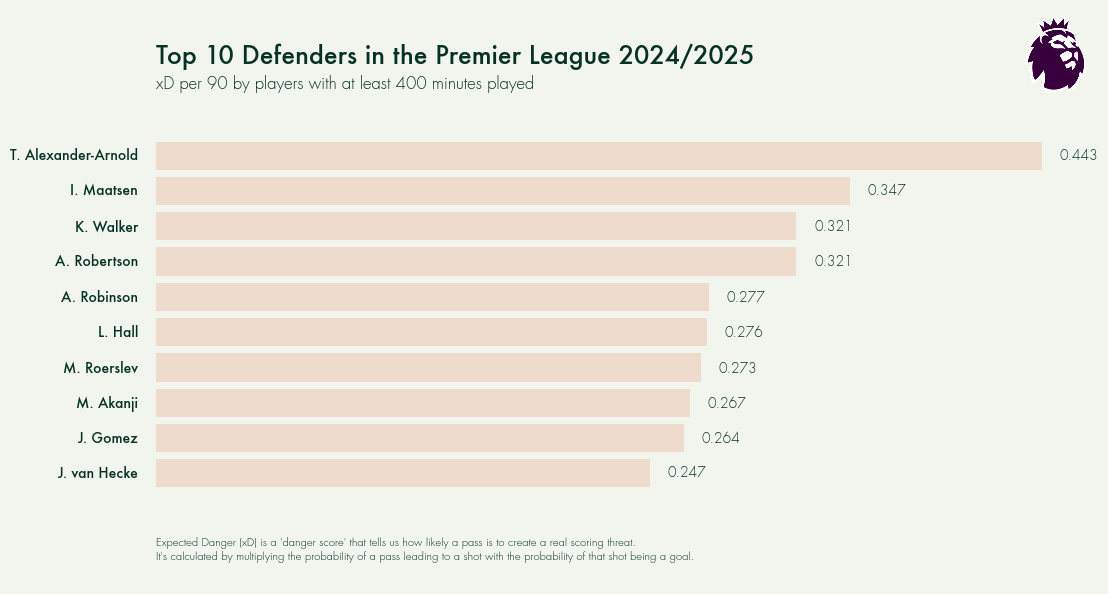

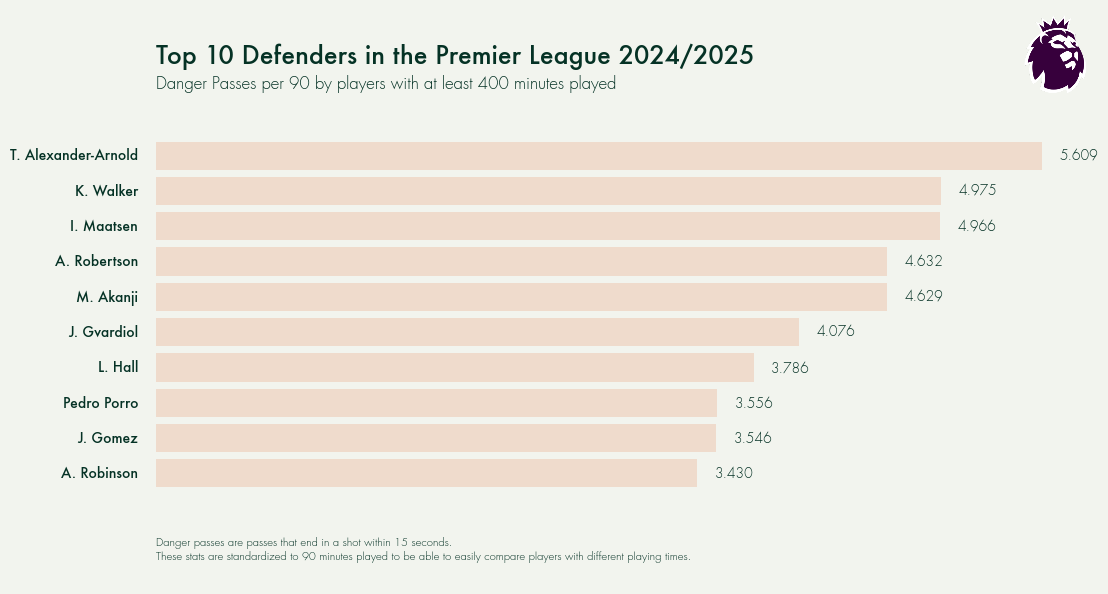

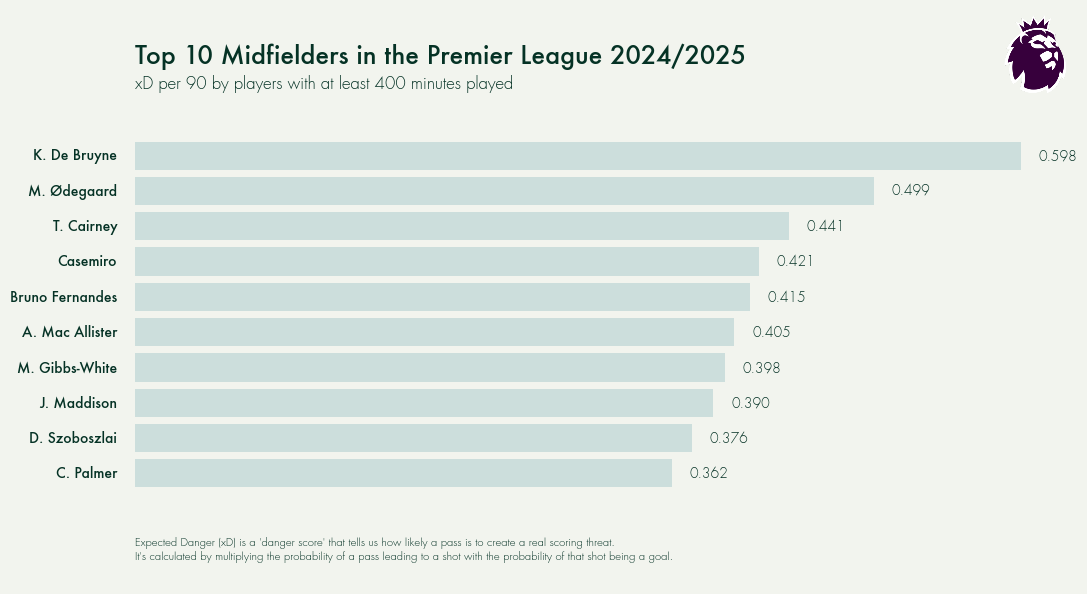

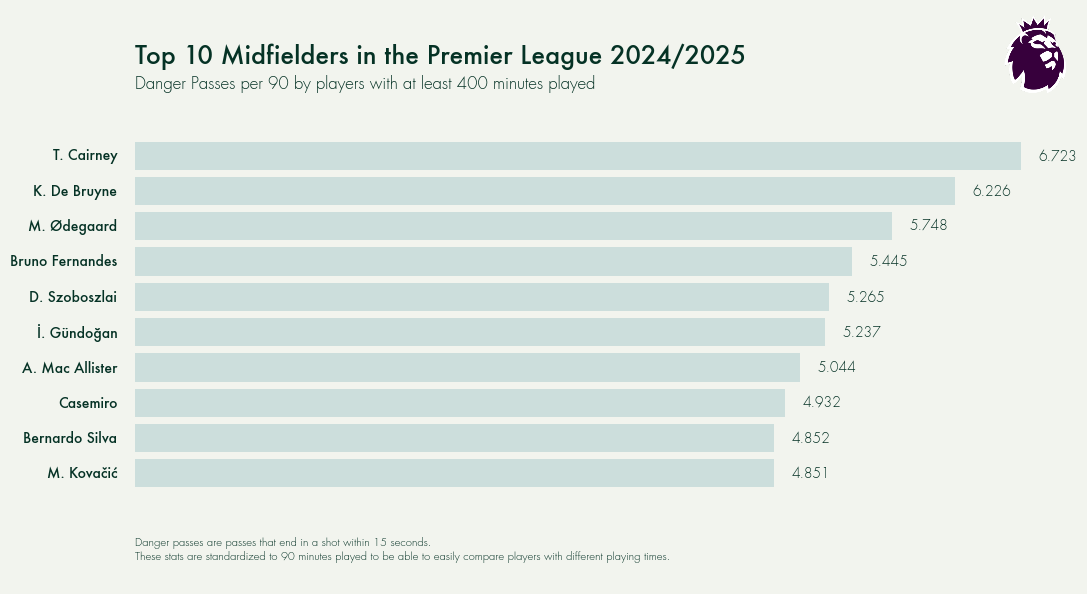

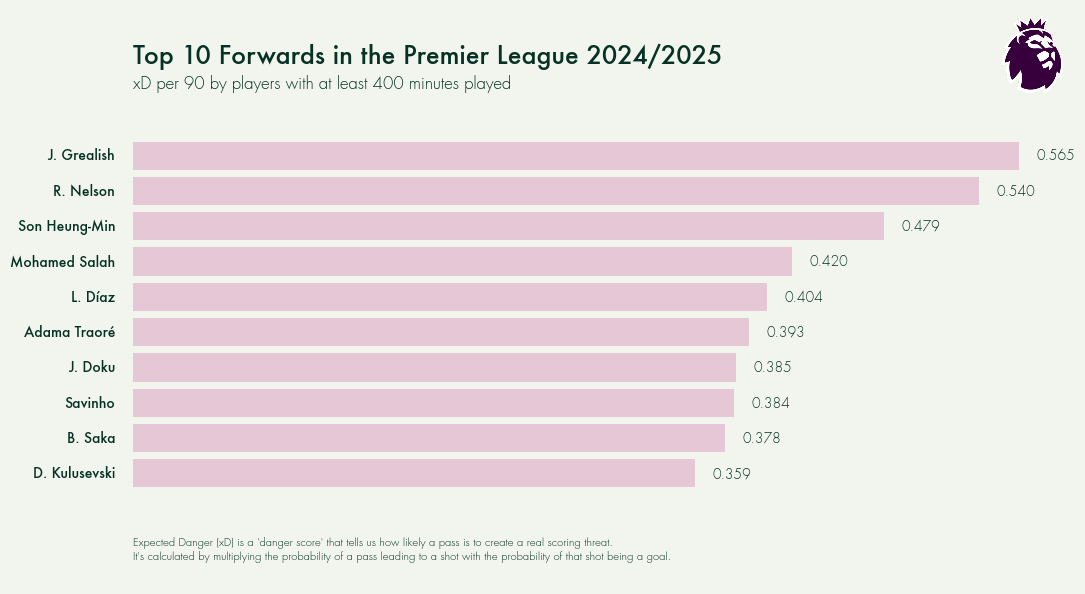

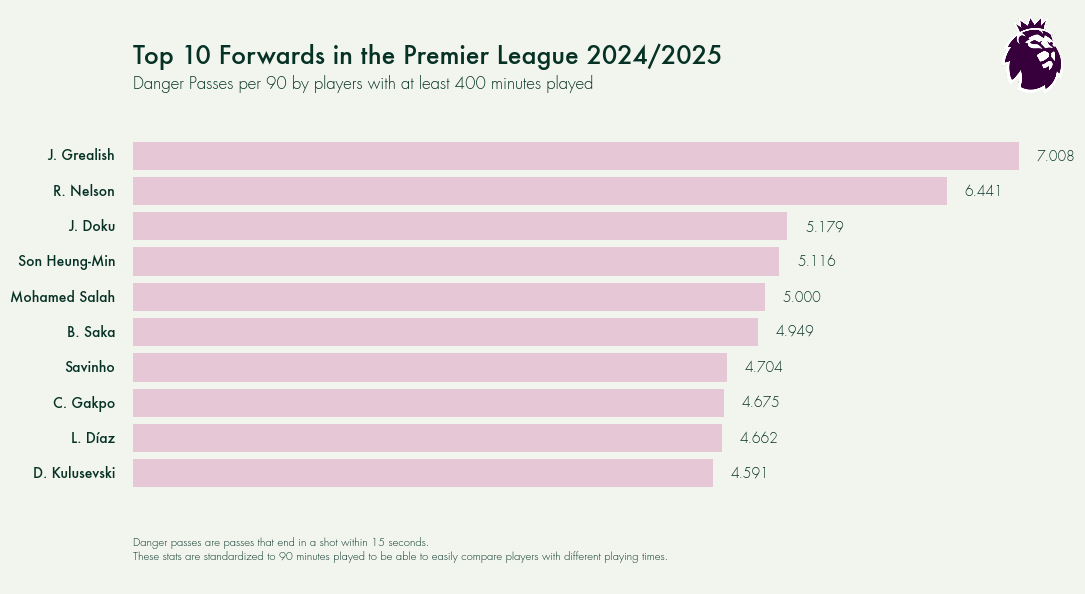

In [93]:
for role in ["Goalkeeper", "Defender", "Midfielder", "Forward"]:
    for metric in ["xD_per_90", "danger_passes_per_90"]:
        create_ranking_plot(
            data[data['role'] == role].sort_values(by=metric, ascending=True).tail(10).reset_index(drop=True), 
            role, 
            metric, 
            10
        )